__CCD Data__

In this example, we'll use the 'ccd' module to 'simulate' ccd imaging of a strong lens made using a tracer. By simulate, we mean that it will appear as if we had observed it using a real telescope, with this example making an image representative of Hubble Space Telescope imaging.

In [1]:
%matplotlib inline

from autolens.data import ccd
from autolens.data import simulated_ccd
from autolens.data.array import grids
from autolens.lens import ray_tracing
from autolens.model.galaxy import galaxy as g
from autolens.model.profiles import light_profiles as lp
from autolens.model.profiles import mass_profiles as mp
from autolens.lens.plotters import ray_tracing_plotters
from autolens.data.plotters import ccd_plotters

To simulate an image, we need to model the telescope's optics. We'll do this by convolving the image with a Point-Spread Function, which we can simulate as a Gaussian using the imaging module.

In [2]:
psf = ccd.PSF.from_gaussian(
    shape=(11, 11), sigma=0.1, pixel_scale=0.1)

To simulate ccd data, we use a special type of grid. This grid pads its 2D dimensions relative to the PSF-shape, to ensure that the edge's of our simulated image are not degraded.

In [3]:
image_plane_grid_stack = grids.GridStack.grid_stack_for_simulation(
    shape=(100, 100), pixel_scale=0.1, psf_shape=psf.shape)

print(image_plane_grid_stack.regular.image_shape)
print(image_plane_grid_stack.regular.padded_shape)

(100, 100)
(110, 110)


Now, lets setup our lens galaxy, source galaxy and tracer.

In [4]:
lens_galaxy = g.Galaxy(
    redshift=0.5, 
    mass=mp.EllipticalIsothermal(centre=(0.0, 0.0), einstein_radius=1.6, axis_ratio=0.7, phi=45.0))

source_galaxy = g.Galaxy(
    redshift=1.0, 
    light=lp.EllipticalSersic(centre=(0.1, 0.1), axis_ratio=0.8, phi=45.0, intensity=1.0, effective_radius=1.0, 
                              sersic_index=2.5))

tracer = ray_tracing.TracerImageSourcePlanes(
    lens_galaxies=[lens_galaxy], source_galaxies=[source_galaxy], image_plane_grid_stack=image_plane_grid_stack)

Lets look at the tracer's image-plane image - this is the image we'll be simulating.

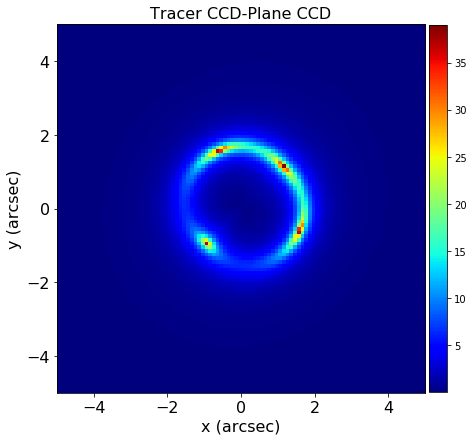

In [5]:
ray_tracing_plotters.plot_image_plane_image(
    tracer=tracer)

To simulate the image, we don't use the image-plane image plotted above. Instead, we use an image-plane image which has been generated specifically for simulating an image, using the padded grid above. This ensures edge-effects do not degrade our simulation's PSF convolution.

In [7]:
print(tracer.profile_image_plane_image_2d.shape)
print(tracer.profile_image_plane_image_2d_for_simulation.shape)

(100, 100)
(110, 110)


Now, to simulate the ccd imaging data, we pass the tracer's image-plane image to the ccd module's simulate function. This adds the following effects to the image:

1) Telescope optics: Using the Point Spread Function above.

2) The Background Sky: Although the image that is returned is automatically background sky subtracted.

3) Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.

In [9]:
simulated_ccd = simulated_ccd.SimulatedCCDData.from_image_and_exposure_arrays(
    image=tracer.profile_image_plane_image_2d_for_simulation, pixel_scale=0.1, 
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_noise=True)

Lets plot the image - we can see the image has been blurred due to the telescope optics and noise has been added.

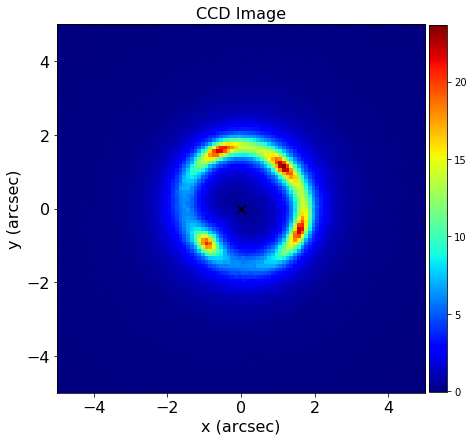

In [10]:
ccd_plotters.plot_image(ccd_data=simulated_ccd)

Finally, lets output these files to.fits files, we'll begin to analyze them in the next tutorial!

In [9]:
# You need to change the path below to the chapter 1 directory.
chapter_path = '/path/to/workspace/howtolens/chapter_1_introduction/'

# The data path specifies where the data is output, this time in the directory 'chapter_path/data'
data_path = chapter_path + 'data/'

# Now output our simulated data to hard-disk.
ccd.output_ccd_data_to_fits(
    ccd_data=simulated_ccd, 
    image_path=data_path+'image.fits',
    noise_map_path=data_path+'noise_map.fits',
    psf_path=data_path+'psf.fits',
    overwrite=True)